# Moment-Shear (MV) Interaction Analysis of DNN predictions

**Author**: Benjamin Urben<br>
**Email**: burben@student.ethz.ch / benjamin.urben@hotmail.ch<br>
**Context**: Master Thesis on "Use of Conditional Variational Autoencoder (cVAE) in the design of connections"<br>
**Institution**: ETH Zürich, Institute of Structural Engineering (IBK)

**Description**:

Analyse the **shape** of the MV interaction by creating an alogrithm, which cluster similar **shapes**. This helps to understand where model error and uncertainty stems from by analysing features and metrics of certain **shape** clusters. 

**Dependencies**: 
- `DNN.py`
- `Datareader.py`
- `Settings.py`
- `Saved Models\DNN_Model_Full_V2\DNN_Model_Full_V2.pth`

**Generates**:
- `Saved Variables\interaction_kmeans.pkl`
- `Saved Variables\interaction_pca.pkl`

## Setup

### Import

In [5]:
import os
import importlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.cluster import KMeans

from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy import stats

import torch
import torch.nn as nn
import torch.optim as optim

from Settings import Directory, Plotting_Parameters
from DataReader import DataReader
from DNN import DNN

import warnings
warnings.filterwarnings('ignore')

### Directory

In [6]:
directory = Directory()
plot_params = Plotting_Parameters()

model_name = "DNN_Model_Full_V2"

DATA_FILE = r"Data\Knee_Connection_Output_red.csv"
MODEL_SAVE_PATH = os.path.join("Saved Models", model_name)

MODEL_SAVE_FILE = os.path.join(MODEL_SAVE_PATH, f"{model_name}.pth")

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


## Load Data & Model

In [7]:
datareader = DataReader()
df_full = datareader.load("Knee_Connection_Output_red.csv")

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks
df_full_filtered.csv
Extended_Database.csv
Extended_Database_filtered_converted.csv
Extended_Database_FilterOn.csv
extended_profiles_filteron_iter_1.csv
extended_profiles_iter_1.csv
extended_profiles_iter_2.csv
extended_profiles_iter_3.csv
GAL_Generated_Data.csv
Knee_Connection_Output_red.csv
Knee_parallel_I_Off0_Output_red_Q1.xlsx
Knee_parallel_I_Off0_Output_red_Q4.xlsx
Knee_parallel_I_Output_Q1.xlsx
Knee_parallel_I_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Output_red_Q4.xlsx
Knee_widener_I_Output_Off0_red_Q1.xlsx
Knee_widener_I_Output_red_Q1.xlsx
_OLD
Knee_Connection_Output_red.csv: (714385, 53)


In [8]:
model = DNN()
model = torch.load(MODEL_SAVE_FILE)
df = df_full.loc[model.data['data_indeces']]

for key, value in model.config.items():
    print(key, value)

print(model.data['data_reduction_factor'])

batch_size 256
epochs 3000
learning_rate 0.001
test_size 0.1
val_size 0.1
print_logs True
dropout_prob 0.0
num_layers 3
neurons_per_layer [128, 64, 32, 16, 8]
use_batch_norm True
seed 42
description Use larger network architecture and more features as training data. Also use Batch normalization
0


## Get Test Set Metrics

In [ ]:
df_test = df_full.loc[model.data['test_data']]

y_pred, test_loss = model.evaluate()
y_pred = y_pred.numpy()
y_true = model.y_test.numpy()
model.get_metrics(y_pred)

mcd_mean, mcd_std, _ = model.mc_dropout_uncertainty(df_input=df_test, num_samples=1000, dropout_prob=0.1)

uncertainty = mcd_std / mcd_mean

In [19]:
df_model_metrics = pd.DataFrame(data={'id':np.array(model.data['test_data']),
                                      'y_true': y_true.flatten(), 
                                      'y_pred': y_pred.flatten(), 
                                      'uncertainty': uncertainty.flatten()},
                                      index=model.data['test_data'])

## MV Interaction Predictions

### Relevant Functions

Function to find profiles with the same geometric features, but different Moment/Shear loads in the dataset. Used to create ground truth values for the MV Interaction diagram.

In [20]:
def find_similar_profiles(x_profile,log=True):
    # Get the fixed features (all except M_contribution and V_contribution)
    fixed_features = [feat for feat in model.features if feat not in ['M_contribution', 'V_contribution']]

    x_profile_key = tuple(x_profile[fixed_features].values.astype(np.float32))
    all_profiles_df = pd.DataFrame(model.x_data, columns=model.features)
    
    # Create mask for matching profiles
    mask = np.ones(len(all_profiles_df), dtype=bool)
    
    # Apply filter for each fixed feature
    for i, feature in enumerate(fixed_features):
        feature_idx = model.features.index(feature)
        mask &= (all_profiles_df.iloc[:, feature_idx] == x_profile_key[i])
    
    profiles_similar = np.where(mask)[0].tolist()
    
    if log==True:
        print(f'{len(profiles_similar)} profiles found with the same fixed features')
    
    return profiles_similar

In [47]:
def get_figsize(fraction, document_width=15.92, aspect_ratio=None):
    width_in = document_width / 2.54 * fraction

    if aspect_ratio is None:
        aspect_ratio = (5 ** 0.5 - 1) / 2  # golden ratio

    height_in = width_in / aspect_ratio
    return width_in, height_in

In [60]:
def plot_MV_interaction(x_profile,M_Rd_pred,V_Rd_pred):
    profiles_similar = find_similar_profiles(x_profile)

    M_Rd_truth = df["M_Rd"].to_numpy()[profiles_similar]
    V_Rd_truth = df["V_Rd"].to_numpy()[profiles_similar]
    
    fig, ax = plt.subplots(figsize=(plot_params.get_figsize(1/2,aspect_ratio=1.0)))
    plt.plot(M_Rd_pred, V_Rd_pred, 
             marker='o',
             markersize=5,
             color = plot_params.morecolors[1],
             markerfacecolor=plot_params.morecolors[1],
             markeredgecolor=plot_params.morecolors[0],                    
             label="Predicted",
             zorder=2)

    plt.scatter(M_Rd_truth, V_Rd_truth,
                s=40, 
                color=plot_params.morecolors[7], 
                edgecolors=plot_params.morecolors[6],  
                linewidth=1,
                label="Data",
                zorder=2)

    ax.fill_between(M_Rd_pred, V_Rd_pred, color=plot_params.morecolors[1], alpha=0.2, zorder=1)

    plt.xlabel(plot_params.feature_labels["M_Rd"])
    plt.ylabel(plot_params.feature_labels["V_Rd"])
    #plt.grid(True, which='major', color='k', linestyle='--', linewidth=0.5, alpha=0.5, zorder=0)
    plt.xlim([0,None])
    plt.ylim([0,None])
    plt.legend()

    plt.show()

### Visualize

Select Profile

In [59]:
import Settings
importlib.reload(Settings)
from Settings import Directory, Plotting_Parameters
plot_params = Plotting_Parameters()

5 profiles found with the same fixed features


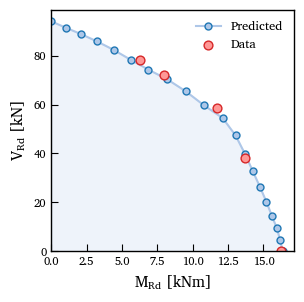

4 profiles found with the same fixed features


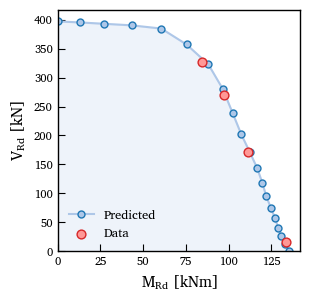

14 profiles found with the same fixed features


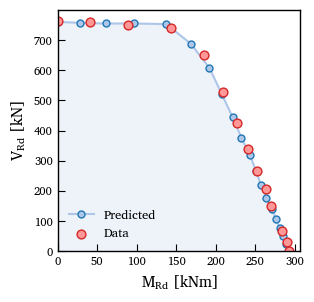

2 profiles found with the same fixed features


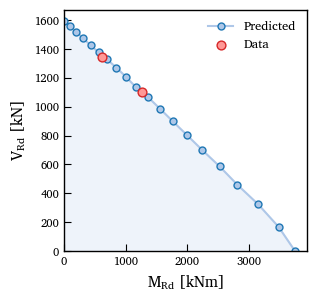

3 profiles found with the same fixed features


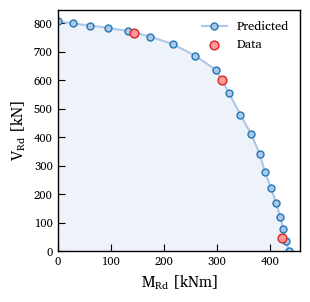

8 profiles found with the same fixed features


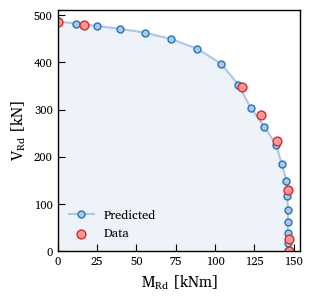

4 profiles found with the same fixed features


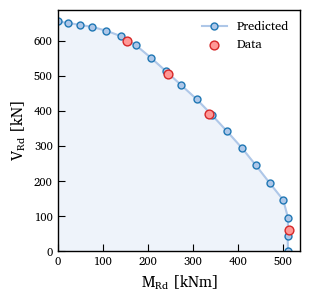

6 profiles found with the same fixed features


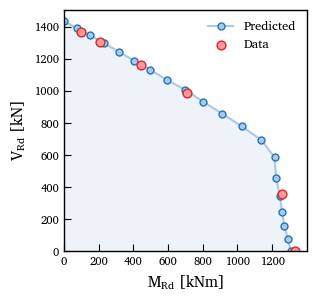

5 profiles found with the same fixed features


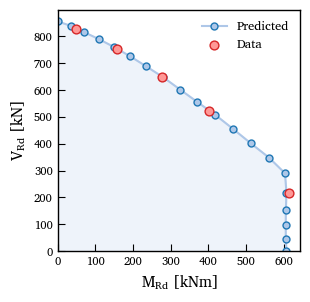

3 profiles found with the same fixed features


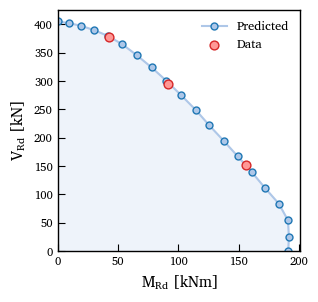

In [61]:
profiles_ids = np.random.randint(0, len(df), 10)
for profile_id in profiles_ids:
    x_profile = df.iloc[profile_id]
    M_Rd_pred, V_Rd_pred, targets_predicted = model.get_MV_interaction_prediction(x_profile,n_predictions=20)
    plot_MV_interaction(x_profile,M_Rd_pred,V_Rd_pred)

## Cluster Interaction Curve Shapes

### Relevant Functions

In [77]:
def normalize_curve(points):
    points = np.array(points)
    max_val = np.max(points) #max_vals = np.max(points, axis=0) (Both axes fixed on (1,0), (1,0)
    return points / max_val

def resample_curve(points, num_points=100):
    points = np.array(points)
    dist = np.cumsum(np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1)))
    dist = np.insert(dist, 0, 0)
    uniform_dist = np.linspace(0, dist[-1], num_points)
    interp_func = interp1d(dist, points, axis=0)
    return interp_func(uniform_dist)

def flatten_curve(points):
    return points.flatten()

def preprocess_curves(curves, num_points=100):
    return [flatten_curve(resample_curve(normalize_curve(c), num_points)) for c in curves]

def cluster_curves(curves, n_clusters, return_fit=False):
    data = preprocess_curves(curves)
    pca = PCA(n_components=10)
    reduced = pca.fit_transform(data)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(reduced)
    if return_fit:
        return kmeans.labels_, data, pca, kmeans
    else:
        return kmeans.labels_, data

### Create Clusters

#### Get MV interaction curves

In [63]:
#n_samples = 150
#x_profiles = df_test.sample(n_samples)
x_profiles = df_test.copy()

#### Build all interactions

In [64]:
interactions = []
interactions_metrics = {'ids': [],
                  'n_profiles': [],
                  'y_preds': [],
                  'uncertainty': [],
                  'y_trues': [],
                  'error': []
                  }

for i,x_profile in x_profiles.iterrows():
    profiles_similar = find_similar_profiles(x_profile,log=False)
    M_Rd_pred, V_Rd_pred, targets_predicted = model.get_MV_interaction_prediction(x_profile,n_predictions=20)

    profiles_similar.append(x_profile.name)

    interactions_metrics['ids'].append(profiles_similar)
    interactions_metrics['n_profiles'].append(len(profiles_similar))

    interactions.append(np.array(list(zip(M_Rd_pred, V_Rd_pred))))

    profiles_similar_testdata = [x for x in profiles_similar if x in model.data['test_data']]

    error = df_model_metrics.loc[profiles_similar_testdata, 'y_pred'].to_numpy() - df_model_metrics.loc[profiles_similar_testdata, 'y_true'].to_numpy()
    error = np.abs(error) / (df_model_metrics.loc[profiles_similar_testdata, 'y_true'].to_numpy()+1e-8)

    interactions_metrics['error'].append(error)
    interactions_metrics['y_preds'].append(df_model_metrics.loc[profiles_similar_testdata, 'y_pred'])
    interactions_metrics['uncertainty'].append(df_model_metrics.loc[profiles_similar_testdata, 'uncertainty'].to_numpy())
    interactions_metrics['y_trues'].append(df_model_metrics.loc[profiles_similar_testdata, 'y_true'])

df_interactions_metrics = pd.DataFrame(interactions_metrics)

KeyboardInterrupt: 

In [20]:
df_interactions_metrics['mv_mean_error'] = df_interactions_metrics['error'].apply(np.mean)
df_interactions_metrics['mv_mean_uncertainty'] = df_interactions_metrics['uncertainty'].apply(np.mean)

In [22]:
df_interactions_metrics.to_pickle(r'Saved Variables\interactions_metrics.pkl')

In [24]:
np.save(r'Saved Variables\interactions.npy', interactions)

### Load all interactions (instead of building)

In [ ]:
with open(r'Saved Variables\interactions_metrics.pkl', 'rb') as file:
    df_interactions_metrics = pickle.load(file)

interactions = np.load(r'Saved Variables\interactions.npy')

### Clustering

In [ ]:
n_clusters = 12
clusters, interactions_normed, pca, kmeans = cluster_curves(interactions,n_clusters=n_clusters,return_fit=True)
interactions_normed = np.array(interactions_normed)
df_interactions_metrics['cluster'] = clusters

#### Save

In [ ]:
with open(r"Saved Variables\interaction_pca.pkl", "wb") as file:
    pickle.dump(pca, file)

with open(r"Saved Variables\interaction_kmeans.pkl", "wb") as file:
    pickle.dump(kmeans, file)

### Visualize


Differentiate between stiffener + widener, no stiffnener no widener, one

High gamma bad predcitons

split clusterin

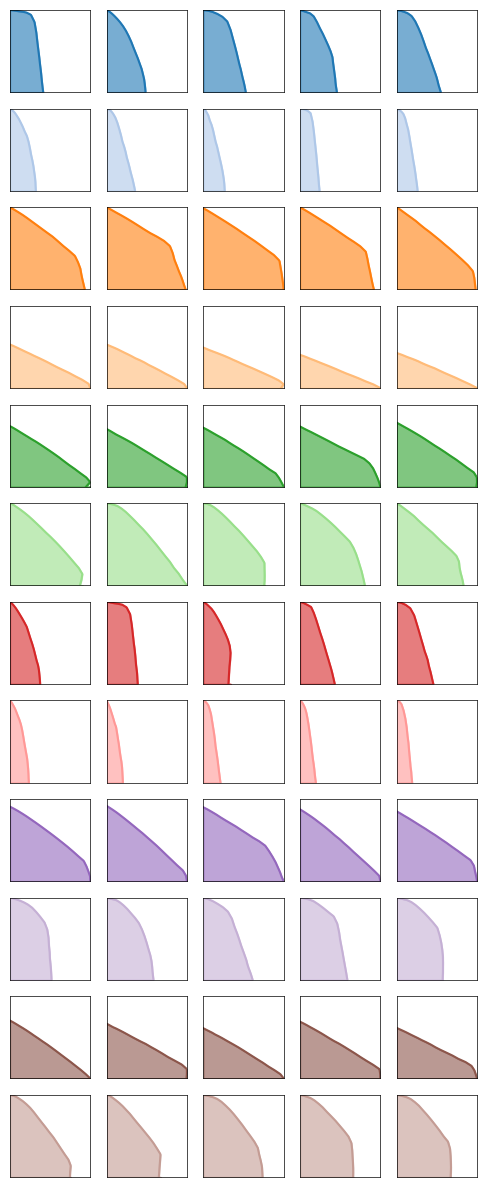

In [72]:
plots_per_label = 5

fig, axs = plt.subplots(n_clusters, plots_per_label, figsize=(plots_per_label, n_clusters), sharex=True, sharey=True)

for cluster in range(n_clusters):
    curves_norm_label = interactions_normed[clusters == cluster]
    for j in range(plots_per_label):
        ax = axs[cluster, j % plots_per_label]
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])

        x = curves_norm_label[j][::2]
        y = curves_norm_label[j][1::2]
        color = plot_params.morecolors[cluster]

        ax.plot(x, y, color=color, linewidth=1.5)
        ax.fill_between(x, 0, y, color=color, alpha=0.6)

        ax.set_xticks([])
        ax.set_yticks([])

        for spine in ax.spines.values():
            spine.set_linewidth(0.5)

plt.tight_layout()
plt.show()

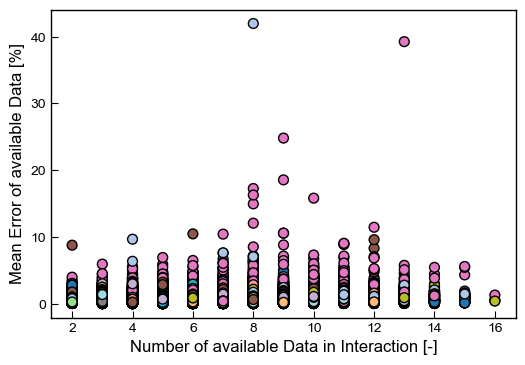

In [203]:
fig, ax = plt.subplots(figsize=(6, 4))

plt.scatter(df_interactions_metrics['n_profiles'], df_interactions_metrics['mv_mean_error']*100,
            c=df_interactions_metrics['cluster'], 
            cmap='tab20', 
            edgecolor='k', 
            s=50)

plt.xlabel('Number of available Data in Interaction [-]')
plt.ylabel('Mean Error of available Data [%]')

plt.show()

In [78]:
def plot_clusters_2d(curves, labels):
    data = preprocess_curves(curves)
    pca_2d = PCA(n_components=2)
    reduced_data = pca_2d.fit_transform(data)
    labels = np.array(labels)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='tab10', s=30)
    plt.title("2D PCA of Curves Colored by Cluster")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(scatter, label='Cluster')
    plt.tight_layout()
    plt.show()

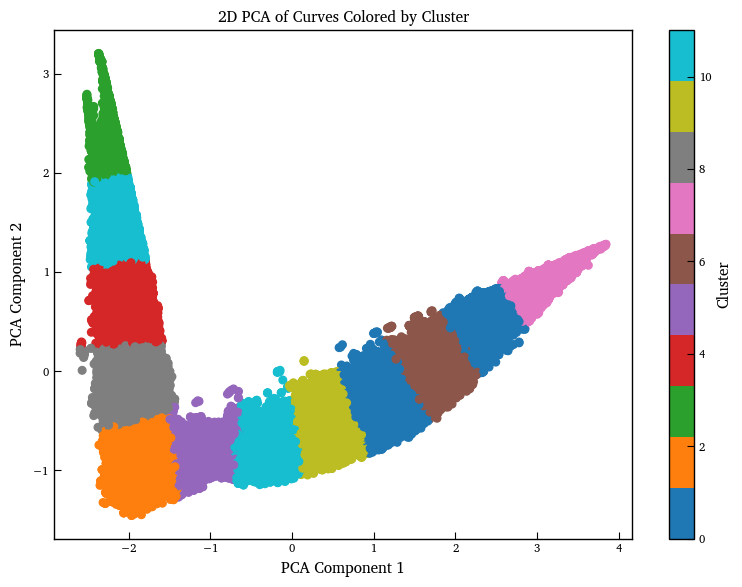

In [79]:
plot_clusters_2d(interactions, clusters)

In [ ]:
interactions

Summarize metrics of samples from each clusters.

In [204]:
labels_summary = {'cluster': [],
                   'n_profiles': [],
                   'mean_error': [],
                   'std_error': [],
                   'mean_uncertainty':[],
                   'std_uncertainty':[],
                     'mean_target': [],
                     'std_target': []
                   }

for label in range(n_clusters):
    df_label = df_interactions_metrics[df_interactions_metrics['cluster'] == label]
    labels_summary['cluster'].append(label)
    labels_summary['n_profiles'].append(df_label['n_profiles'].mean())
    labels_summary['mean_error'].append(df_label['mv_mean_error'].mean())
    labels_summary['std_error'].append(df_label['mv_mean_error'].std())
    labels_summary['mean_uncertainty'].append(df_label['mv_mean_uncertainty'].mean())
    labels_summary['std_uncertainty'].append(df_label['mv_mean_uncertainty'].std())
    labels_summary['mean_target'].append(np.mean([item for sublist in df_label['y_trues'].values for item in sublist]))
    labels_summary['std_target'].append(np.std([item for sublist in df_label['y_trues'].values for item in sublist]))

df_labels_summary = pd.DataFrame(labels_summary)

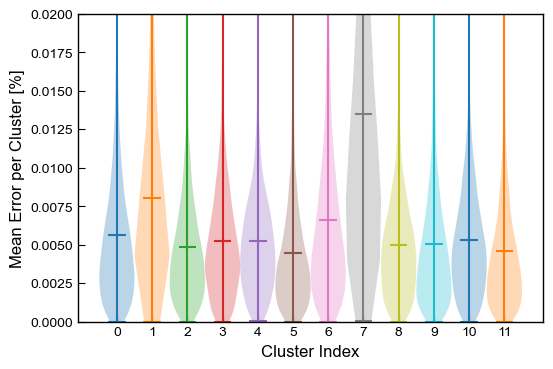

In [205]:
fig, axs = plt.subplots(figsize=(6, 4))

for label in range(n_clusters):
        plt.violinplot(df_interactions_metrics[df_interactions_metrics['cluster']==label]['mv_mean_error'].values, 
                       showmeans=True,
                       showextrema=True,
                       widths=1.0,
                       positions=[label])

plt.ylim([0,0.02])

# Labels and title
plt.xlabel("Cluster Index")
plt.ylabel("Mean Error per Cluster [%]")
plt.xticks(np.arange(n_clusters), range(n_clusters))

plt.show()

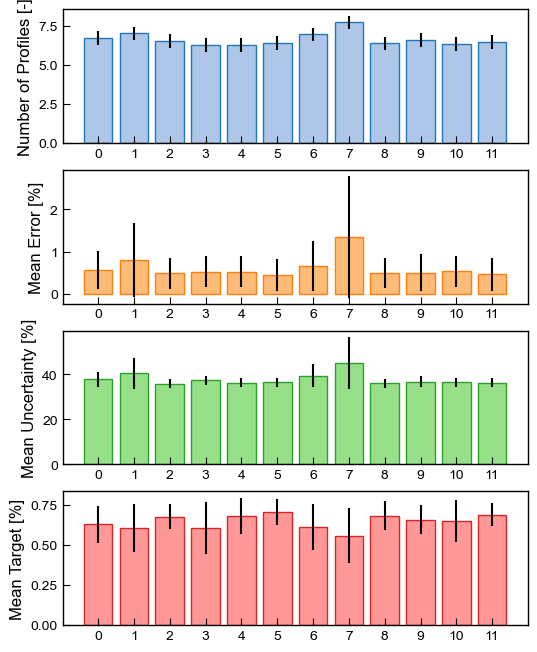

In [206]:
fig, axs = plt.subplots(4,1,figsize=(6, 8))

axs[0].bar(df_labels_summary['cluster'], df_labels_summary['n_profiles'], 
           yerr=df_labels_summary['n_profiles'].std(),
           color=plot_params.morecolors[1],
           edgecolor=plot_params.morecolors[0])
axs[0].set_ylabel("Number of Profiles [-]")
axs[0].set_xticks(np.arange(n_clusters))

axs[1].bar(df_labels_summary['cluster'], df_labels_summary['mean_error']*100, 
           yerr=df_labels_summary['std_error']*100, 
           color=plot_params.morecolors[3],
           edgecolor=plot_params.morecolors[2])
axs[1].set_ylabel("Mean Error [%]")
axs[1].set_xticks(np.arange(n_clusters))

axs[2].bar(df_labels_summary['cluster'], df_labels_summary['mean_uncertainty']*100, 
           yerr=df_labels_summary['std_uncertainty']*100, 
           color=plot_params.morecolors[5],
           edgecolor=plot_params.morecolors[4])
axs[2].set_ylabel("Mean Uncertainty [%]")
axs[2].set_xticks(np.arange(n_clusters))

axs[3].bar(df_labels_summary['cluster'], df_labels_summary['mean_target'],
           yerr=df_labels_summary['std_target'], 
           color=plot_params.morecolors[7],
           edgecolor=plot_params.morecolors[6])
axs[3].set_ylabel("Mean Target [%]")
axs[3].set_xticks(np.arange(n_clusters))

plt.show()

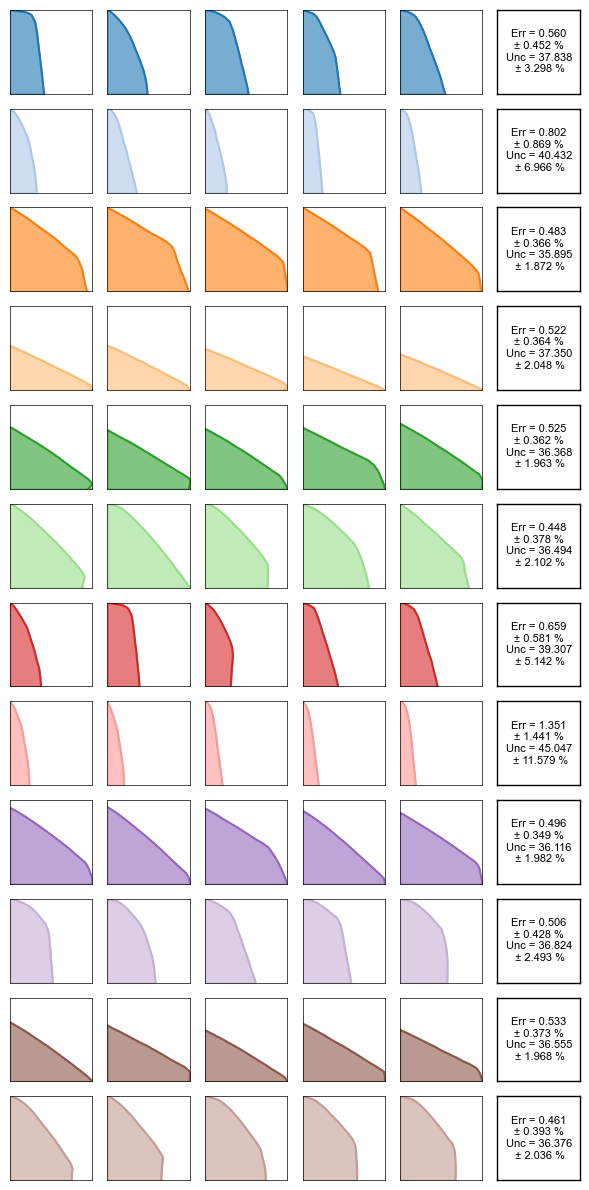

In [207]:
plots_per_label = 5

fig, axs = plt.subplots(n_clusters, plots_per_label+1, figsize=(plots_per_label+1, n_clusters), sharex=True, sharey=True)

for cluster in range(n_clusters):
    interactions_cluster = interactions_normed[clusters==cluster]
    for j in range(plots_per_label):
        ax = axs[cluster, j % plots_per_label]
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])

        x = interactions_cluster[j][::2]
        y = interactions_cluster[j][1::2]
        color = plot_params.morecolors[cluster]

        ax.plot(x, y, color=color, linewidth=1.5)
        ax.fill_between(x, 0, y, color=color, alpha=0.6)

        ax.set_xticks([])
        ax.set_yticks([])

        for spine in ax.spines.values():
            spine.set_linewidth(0.5)
    ax = axs[cluster,-1]
    mean_error = df_labels_summary[df_labels_summary['cluster']==cluster]['mean_error'].values[0]
    std_error = df_labels_summary[df_labels_summary['cluster']==cluster]['std_error'].values[0]
    mean_uncertainty = df_labels_summary[df_labels_summary['cluster']==cluster]['mean_uncertainty'].values[0]
    std_uncertainty = df_labels_summary[df_labels_summary['cluster']==cluster]['std_uncertainty'].values[0]
    ax.annotate(f"Err = {mean_error*100:.3f}\n± {std_error*100:.3f} %\nUnc = {mean_uncertainty*100:.3f}\n ± {std_uncertainty*100:.3f} %", 
                xy=(0.5, 0.5), ha='center', va='center', fontsize=8,)

plt.tight_layout()
plt.show()

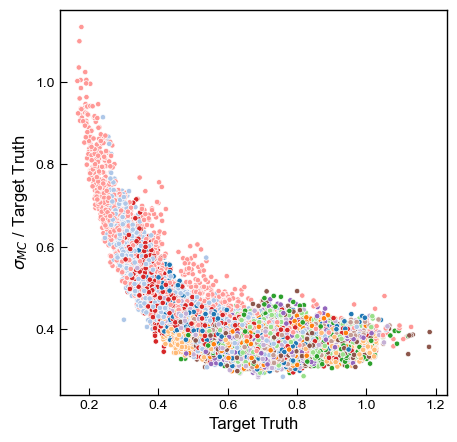

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(y_true, uncertainty, 
            s=15, 
            facecolor=np.array(plot_params.morecolors)[df_interactions_metrics['cluster'].values], 
            edgecolors='white',
            linewidth=0.5,
            zorder=1)
plt.xlabel("Target Truth")
plt.ylabel("$\sigma_{MC}$ / Target Truth")

plt.show()

In [233]:
def plot_all_features_violin(X, labels, model):
    m = np.max(labels) + 1
    n_features = X.shape[1]
    
    fig, axes = plt.subplots(nrows=n_features, figsize=(7, 2 * n_features))
    if n_features == 1:
        axes = [axes]

    for feature_idx in range(n_features):
        data = []
        for k in range(m):
            for val in X[labels == k, feature_idx]:
                data.append((k, val))
        df = pd.DataFrame(data, columns=["Cluster", "Value"])

        sns.violinplot(x="Cluster", y="Value", data=df, ax=axes[feature_idx], linewidth=1.0, palette='tab20')
        axes[feature_idx].set_ylabel(model.features[feature_idx])
        axes[feature_idx].set_xlabel('')
        axes[feature_idx].set_xticks([])
        axes[feature_idx].set_yticks([])

    plt.tight_layout()
    plt.show()

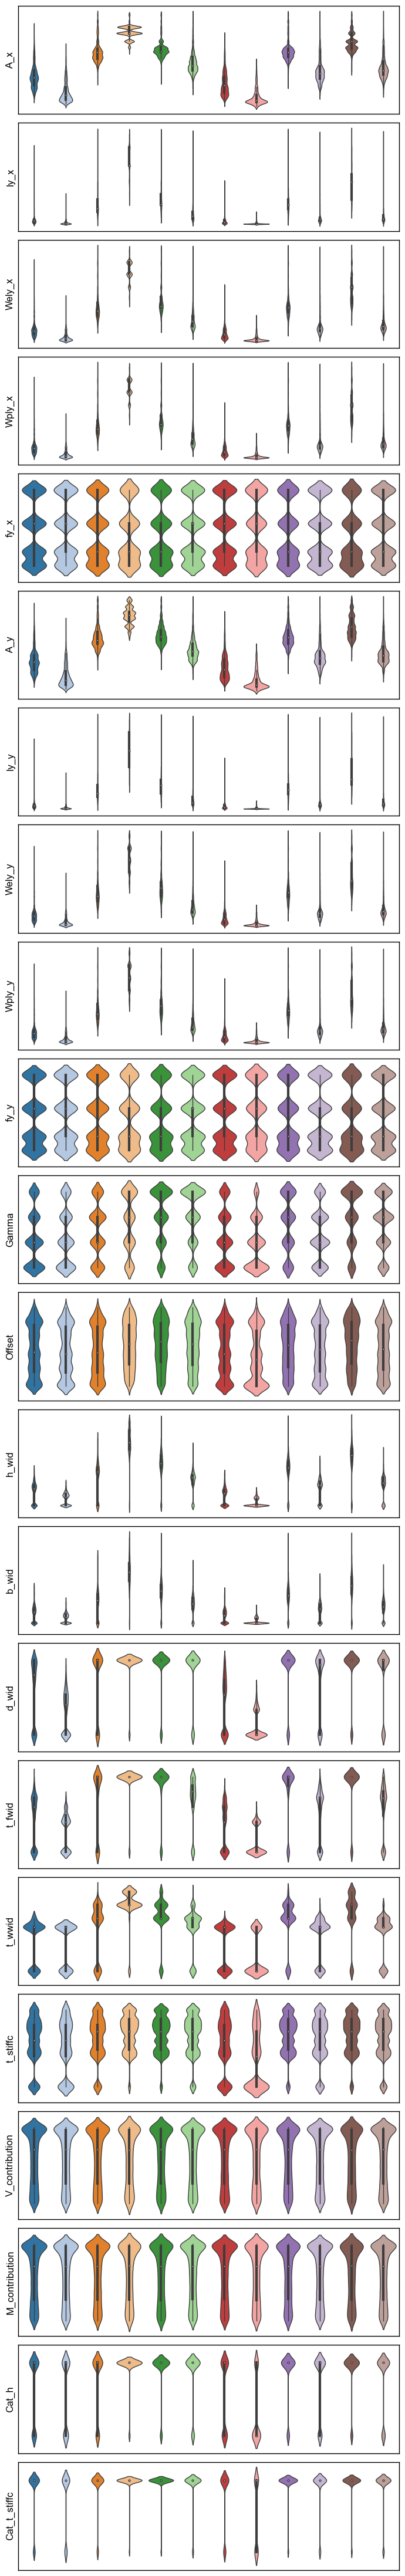

In [234]:
plot_all_features_violin(df_test[model.features].values, df_interactions_metrics['cluster'].values, model)

## Adaptive Interaction Curve Calculation (Work in Progress)

Create a algorithm to incrase resolution of M-V interaction curve without blindly increasing the computational effort by adding more interaction samples. Algorithm adds more samples in regions of high nonlinearity and fewer in linear parts.

In [ ]:
def adaptive_unit_vectors(n_start=2, max_refinements=100, angle_threshold_deg=5):
    def unit_arc(n):
        M = np.linspace(1, 0, n)
        V = np.linspace(0, 1, n)
        norms = np.sqrt(M**2 + V**2)
        return np.stack((M / norms, V / norms), axis=1)

    def angle_between(a, b):
        a_norm = a / np.linalg.norm(a)
        b_norm = b / np.linalg.norm(b)
        cos_theta = np.clip(np.dot(a_norm, b_norm), -1, 1)
        return np.arccos(cos_theta) * 180 / np.pi

    vectors = unit_arc(n_start).tolist()

    for _ in range(max_refinements):
        new_vectors = [vectors[0]]
        for i in range(1, len(vectors)):
            a = np.array(vectors[i - 1])
            b = np.array(vectors[i])
            angle = angle_between(a, b)
            if angle > angle_threshold_deg:
                mid = (a + b)
                mid /= np.linalg.norm(mid)
                new_vectors.append(mid.tolist())
            new_vectors.append(vectors[i])
        vectors = new_vectors

    vectors = np.unique(np.round(vectors, decimals=6), axis=0)
    vectors = sorted(vectors, key=lambda v: np.arctan2(v[1], v[0]))
    return np.array(vectors)

In [ ]:
def get_MV_interaction_prediction(x_profile):
    model.model.eval()

    x_profile_features = x_profile[model.features].to_numpy().astype(np.float32)
    x_profile_features = x_profile_features.reshape(1, -1)

    vectors = adaptive_unit_vectors()
    M_cont = vectors[:, 0]
    V_cont = vectors[:, 1]
    n_points = len(M_cont)

    targets_predicted = np.zeros(n_points)

    V_cont_index = model.features.index('V_contribution')
    M_cont_index = model.features.index('M_contribution')

    for i in range(n_points):
        x_profile_features[0, V_cont_index] = V_cont[i]
        x_profile_features[0, M_cont_index] = M_cont[i]
        x_profile_std = model.scaler_x.transform(x_profile_features)
        x_profile_std = torch.tensor(x_profile_std, dtype=torch.float32)
        with torch.no_grad():
            targets_predicted[i] = model.model(x_profile_std).cpu().numpy()[0]

    Mpl_y = x_profile['Mpl_y']
    Vpl_y = x_profile['Vpl_y']

    M_Rd_pred = targets_predicted * Mpl_y * M_cont
    V_Rd_pred = targets_predicted * Vpl_y * V_cont

    return M_Rd_pred, V_Rd_pred, targets_predicted


In [ ]:
x_profile = df.iloc[np.random.randint(0, len(df))]

M_Rd_Pred, V_Rd_pred, _ = get_MV_interaction_prediction(x_profile)

In [ ]:
plot_MV_interaction(x_profile,M_Rd_Pred,V_Rd_pred)

#### Work in Progress

In [ ]:
from scipy.signal import savgol_filter

def compute_curvature(x, y):
    x = np.array(x)
    y = np.array(y)
    dx = np.array(np.gradient(x))
    dy = np.array(np.gradient(y))
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    curvature = np.abs(dx * ddy - dy * ddx) / (dx**2 + dy**2)**1.5
    curvature[np.isnan(curvature)] = 0
    curvature[np.isinf(curvature)] = 0
    return curvature

def get_MV_interaction_prediction(x_profile, base_points=30, curvature_thresh=2.0, max_total_points=100):
    model.model.eval()

    x_profile_features = x_profile[model.features].to_numpy().astype(np.float32).reshape(1, -1)
    V_cont_index = model.features.index('V_contribution')
    M_cont_index = model.features.index('M_contribution')

    M_contribution = np.linspace(1, 0, base_points)
    V_contribution = np.linspace(0, 1, base_points)
    norms = np.sqrt(M_contribution**2 + V_contribution**2)
    M_cont = M_contribution / norms
    V_cont = V_contribution / norms

    targets_predicted = []
    for i in range(base_points):
        x_profile_features[0, V_cont_index] = V_cont[i]
        x_profile_features[0, M_cont_index] = M_cont[i]
        x_profile_std = model.scaler_x.transform(x_profile_features)
        x_profile_std = torch.tensor(x_profile_std, dtype=torch.float32)
        with torch.no_grad():
            pred = model.model(x_profile_std).cpu().numpy()[0]
        targets_predicted.append(pred)

    targets_predicted = np.array(targets_predicted)
    Mpl_y = x_profile['Mpl_y']
    Vpl_y = x_profile['Vpl_y']
    M_Rd = targets_predicted * Mpl_y * M_cont
    V_Rd = targets_predicted * Vpl_y * V_cont

    M_smooth = savgol_filter(np.array(M_Rd), 7, 3)
    V_smooth = savgol_filter(np.array(V_Rd), 7, 3)
    curvature = compute_curvature(M_smooth, V_smooth)

    refined_M = [M_Rd[0]]
    refined_V = [V_Rd[0]]
    refined_targets = [targets_predicted[0]]

    for i in range(1, base_points):
        refined_M.append(M_Rd[i])
        refined_V.append(V_Rd[i])
        refined_targets.append(targets_predicted[i])
        if curvature[i] > curvature_thresh:
            if len(refined_M) < max_total_points:
                refined_M.append((M_Rd[i - 1] + M_Rd[i]) / 2)
                refined_V.append((V_Rd[i - 1] + V_Rd[i]) / 2)
                refined_targets.append((targets_predicted[i - 1] + targets_predicted[i]) / 2)

    return np.array(refined_M), np.array(refined_V), np.array(refined_targets)


In [ ]:
x_profile = df.iloc[np.random.randint(0, len(df))]

M_Rd_Pred, V_Rd_pred, _ = get_MV_interaction_prediction(x_profile)